In [1]:
import os
num_threads = "8"
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

In [2]:
import torch
from torchdiffeq import odeint
import numpy as np
import scipy as sp
import sys
sys.path.append("../../src")
import importlib
import matplotlib.pyplot as plt
import fm
torch.set_default_dtype(torch.float32)
device = torch.device('cpu')

/home/stephenz/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [3]:
seed = 1
dim = 10
N = 128
data = torch.load(f"../gaussian/data_seed_{seed}_dim_{dim}_N_{N}.pkl")
x0, x1 = data['x0'], data['x1']
A, mu = data['A'], data['mu']
d, sigma = data['d'], data['sigma']
U = data['U']
ts = torch.tensor([0., 1.])
U0 = torch.tensor([[-0.7988, -0.6016],
        [-0.6016,  0.7988]])
U = U @ U0

N = 64
bm = fm.LinearBridgeMatcher(A, mu)
x0 = torch.vstack([torch.randn(N // 2, 2)*0.1 - 0.5, 
                   torch.randn(N // 2, 2)*0.25 + 0.5
                  ]).to(device)
x0 = x0 @ U.T 
x1 = torch.vstack([torch.randn(N // 2, 2)*0.1 - 2.5, 
                   torch.randn(N // 2, 2)*0.5 + 2.5,
                  ]).to(device)
x1 = x1 @ U.T
t = torch.rand(N).to(device)

(-0.5, 9.5, 9.5, -0.5)

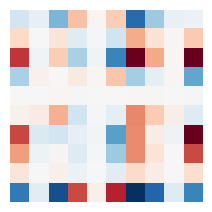

In [4]:
plt.figure(figsize = (2.5, 2.5))
plt.imshow(A, vmin = -1, vmax = 1, cmap = "RdBu_r")
plt.axis("off")

In [5]:
importlib.reload(fm)
otfm = fm.LinearEntropicOTFM(torch.vstack([x0, x1]), 
                      torch.hstack([torch.full((x0.shape[0], ), 0), torch.full((x0.shape[0], ), 1)]), 
                      ts = torch.tensor([0., 1.], dtype = torch.float32),
                      sigma = sigma,
                      A = A,
                      mu = mu,
                      T = 2,
                      dim = d,
                      device = device
                      )
otfm_null = fm.EntropicOTFM(torch.vstack([x0, x1]), 
                      torch.hstack([torch.full((x0.shape[0], ), 0), torch.full((x0.shape[0], ), 1)]), 
                      ts = torch.tensor([0., 1.], dtype = torch.float32),
                      sigma = sigma,
                      T = 2,
                      dim = d,
                      device = device
                      )

/data/gpfs/projects/punim0638/stephenz/envs/lfm/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:1330: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


In [6]:
s_model = fm.MLP(d = d, hidden_sizes = [64, 64, 64], time_varying=True, activation = torch.nn.ReLU)
v_model = fm.MLP(d = d, hidden_sizes = [64, 64, 64], time_varying=True, activation = torch.nn.ReLU)

alpha = 0.5
from tqdm import tqdm
optim = torch.optim.AdamW(list(s_model.parameters()) + list(v_model.parameters()), 3e-3)
for i in tqdm(range(1000)):
    _x, _s, _u, _t, _t_orig = otfm.sample_bridges_flows(batch_size = 64)
    optim.zero_grad()
    s_fit = s_model(_t, _x)
    v_fit = v_model(_t, _x)
    L_score = torch.mean(((_t_orig * (1-_t_orig)) * (s_fit - _s))**2)
    L_flow = torch.mean((_t_orig * (1-_t_orig)*(v_fit - _u))**2)
    L = (1-alpha)*L_score + alpha*L_flow
    if i % 100 == 0:
        print(L_score.item(), L_flow.item())
    L.backward()
    optim.step()

  5%|███████████████▌                                                                                                                                                                                                                                                                                                                    | 48/1000 [00:00<00:04, 236.43it/s]

0.16239264607429504 0.2508682906627655


 15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                   | 148/1000 [00:00<00:03, 240.52it/s]

0.04502790421247482 0.014263087883591652


 25%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                   | 248/1000 [00:01<00:03, 240.28it/s]

0.04110921174287796 0.011282672174274921


 35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 348/1000 [00:01<00:02, 241.45it/s]

0.03776535019278526 0.011221042834222317


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 448/1000 [00:01<00:02, 241.50it/s]

0.039167020469903946 0.010664131492376328


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 548/1000 [00:02<00:01, 239.32it/s]

0.0329408124089241 0.00939903687685728


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 648/1000 [00:02<00:01, 240.64it/s]

0.03396341949701309 0.009489147923886776


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 746/1000 [00:03<00:01, 239.25it/s]

0.02630445919930935 0.010088312439620495


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 842/1000 [00:03<00:00, 239.04it/s]

0.0233827605843544 0.007801042404025793


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 938/1000 [00:03<00:00, 238.96it/s]

0.022954335436224937 0.008231153711676598


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 239.93it/s]


In [7]:
s_model_null = fm.MLP(d = d, hidden_sizes = [64, 64, 64], time_varying=True, activation = torch.nn.ReLU)
v_model_null = fm.MLP(d = d, hidden_sizes = [64, 64, 64], time_varying=True, activation = torch.nn.ReLU)

alpha = 0.5
from tqdm import tqdm
optim = torch.optim.AdamW(list(s_model_null.parameters()) + list(v_model_null.parameters()), 3e-3)
for i in tqdm(range(1_000)):
    _x, _s, _u, _t, _t_orig = otfm_null.sample_bridges_flows(batch_size = 64)
    optim.zero_grad()
    s_fit = s_model_null(_t, _x)
    v_fit = v_model_null(_t, _x)
    L_score = torch.mean(((_t_orig * (1-_t_orig)) * (s_fit - _s))**2)
    L_flow = torch.mean((_t_orig * (1-_t_orig)*(v_fit - _u))**2)
    L = (1-alpha)*L_score + alpha*L_flow
    if i % 100 == 0:
        print(L_score.item(), L_flow.item())
    L.backward()
    optim.step()

 17%|█████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                             | 166/1000 [00:00<00:01, 823.08it/s]

0.18262943625450134 0.03847634047269821
0.029020661488175392 0.0100031066685915


 33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                       | 333/1000 [00:00<00:00, 828.05it/s]

0.02621782384812832 0.007432266138494015
0.021942060440778732 0.0063615478575229645


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 500/1000 [00:00<00:00, 828.39it/s]

0.026736503466963768 0.005992644466459751
0.020118722692131996 0.006685479544103146


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 749/1000 [00:00<00:00, 815.61it/s]

0.017403367906808853 0.0054120225831866264
0.018975961953401566 0.004447920713573694


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 912/1000 [00:01<00:00, 803.82it/s]

0.018257420510053635 0.00470552546903491
0.016039352864027023 0.0037890090607106686


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 814.80it/s]


In [8]:
import torchsde
# _v, _s, what = v_model, s_model, "OU"
_v, _s, what = v_model_null, s_model_null, "BM"
xlims = (-4.5, 4.5)
ylims = (-4.5, 4.5)

sde = fm.SDE(lambda t, x: _v(t, x) + sigma**2 / 2 * _s(t, x), sigma)
_T = 100
with torch.no_grad():
    xs_sde = torchsde.sdeint(sde, torch.tensor(x0), torch.linspace(0, 1, _T), method = "euler")
    xs_ode = odeint(lambda t, x: _v(t, x), torch.tensor(x0), torch.linspace(0, 1, _T))

/tmp/ipykernel_134431/309121552.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs_sde = torchsde.sdeint(sde, torch.tensor(x0), torch.linspace(0, 1, _T), method = "euler")
/tmp/ipykernel_134431/309121552.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs_ode = odeint(lambda t, x: _v(t, x), torch.tensor(x0), torch.linspace(0, 1, _T))


In [9]:
def _project_traj(xs, U):
    return torch.bmm(xs, U.unsqueeze(0).expand(xs.shape[0], *U.shape));
xs_sde_proj = _project_traj(xs_sde, U)
xs_ode_proj = _project_traj(xs_ode, U)
x0_proj, x1_proj = x0 @ U, x1 @ U

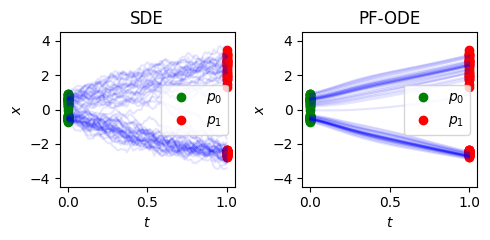

In [10]:
k = 0
plt.figure(figsize = (5, 2.5))
plt.subplot(1, 2, 1)
plt.plot(torch.linspace(0, 1, _T), xs_sde_proj[..., k], color = 'blue', alpha = 0.1);
plt.scatter(torch.zeros_like(x0_proj[:, k]), x0_proj[:, k], c = 'green', label = "$p_0$")
plt.scatter(torch.ones_like(x1_proj[:, k]), x1_proj[:, k], c = 'red', label = "$p_1$")
plt.xlabel("$t$"); plt.ylabel("$x$")
plt.legend()
plt.title("SDE")
plt.ylim(*ylims)
plt.subplot(1, 2, 2)
plt.plot(torch.linspace(0, 1, _T), xs_ode_proj[..., k], color = 'blue', alpha = 0.1);
plt.scatter(torch.zeros_like(x0_proj[:, k]), x0_proj[:, k], c = 'green', label = "$p_0$")
plt.scatter(torch.ones_like(x1_proj[:, k]), x1_proj[:, k], c = 'red', label = "$p_1$")
plt.xlabel("$t$"); plt.ylabel("$x$")
plt.legend()
plt.ylim(*ylims)
plt.title("PF-ODE")
plt.tight_layout()
# plt.savefig(f"../../figures/SB_general_{what}_1d_v_time_seed_{seed}_dim_{dim}_N_{N}.pdf")

In [11]:
x = np.linspace(-5.5, 5.5, 100)
y = np.linspace(-5.5, 5.5, 100)
X, Y = np.meshgrid(x, y)
P = np.eye(d)[:, range(2)]
u, v = U.numpy().T @ (A.numpy() @ ((U.numpy() @ np.vstack([X.flatten(), Y.flatten()])) - mu.numpy()[:, None]))
u = u.reshape(X.shape)
v = v.reshape(X.shape)
# don't plot origin
_mu = mu @ U
_idx = ((X - _mu[0].item())**2 < 1) & ((Y - _mu[1].item())**2 < 1)
u[_idx] = 0
v[_idx] = 0

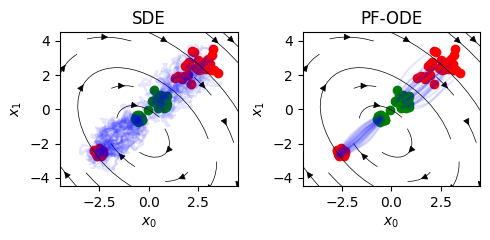

In [12]:
plt.figure(figsize = (5, 2.5))
plt.subplot(1, 2, 1)
plt.streamplot(X, Y, u, v, density=0.3, color='k', linewidth=0.5, arrowsize=1)
plt.plot(xs_sde_proj[..., 0], xs_sde_proj[..., 1], color = 'blue', alpha = 0.1);
plt.scatter(x0_proj[:, 0], x0_proj[:, 1], c = 'green', label = "$p_0$")
plt.scatter(x1_proj[:, 0], x1_proj[:, 1], c = 'red', label = "$p_1$")
plt.xlabel("$x_0$"); plt.ylabel("$x_1$")
# plt.legend()
plt.title("SDE")
plt.xlim(*xlims); plt.ylim(*ylims); 
plt.subplot(1, 2, 2)
plt.streamplot(X, Y, u, v, density=0.3, color='k', linewidth=0.5, arrowsize=1)
plt.plot(xs_ode_proj[..., 0], xs_ode_proj[..., 1], color = 'blue', alpha = 0.1);
plt.scatter(x0_proj[:, 0], x0_proj[:, 1], c = 'green', label = "$p_0$")
plt.scatter(x1_proj[:, 0], x1_proj[:, 1], c = 'red', label = "$p_1$")
# plt.legend()
plt.xlabel("$x_0$"); plt.ylabel("$x_1$")
plt.title("PF-ODE")
plt.xlim(*xlims); plt.ylim(*ylims);
plt.tight_layout()
# plt.savefig(f"../../figures/SB_general_{what}_2d_seed_{seed}_dim_{dim}_N_{N}.pdf")

In [13]:
# varying noise level in forward simulation
xs_sde_sigma = {}
for _sigma in [0.01, 0.5, 1.0, 2.5]:
    sde = fm.SDE(lambda t, x: _v(t, x) + _sigma**2 / 2 * _s(t, x), _sigma)
    _T = 100
    with torch.no_grad():
        xs_sde_sigma[_sigma] = torchsde.sdeint(sde, torch.tensor(x0, dtype = torch.float32), torch.linspace(0, 1, _T), method = "euler")

/tmp/ipykernel_134431/1165776643.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs_sde_sigma[_sigma] = torchsde.sdeint(sde, torch.tensor(x0, dtype = torch.float32), torch.linspace(0, 1, _T), method = "euler")


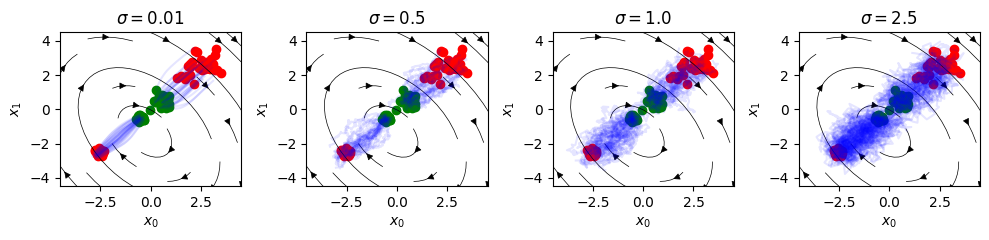

In [14]:
plt.figure(figsize = (10, 2.5))
for i, (_sigma, _xs) in enumerate(xs_sde_sigma.items()):
    _xs_proj = _project_traj(_xs, U)
    plt.subplot(1, 4, i+1)
    plt.streamplot(X, Y, u, v, density=0.3, color='k', linewidth=0.5, arrowsize=1)
    plt.plot(_xs_proj[..., 0], _xs_proj[..., 1], color = 'blue', alpha = 0.1);
    plt.scatter(x0_proj[:, 0], x0_proj[:, 1], c = 'green')
    plt.scatter(x1_proj[:, 0], x1_proj[:, 1], c = 'red')
    plt.xlabel("$x_0$"); plt.ylabel("$x_1$")
    plt.xlim(*xlims); plt.ylim(*ylims)
    plt.title(f"$\\sigma = {_sigma}$")
    plt.tight_layout()
# plt.savefig(f"../../figures/SB_general_{what}_2d_var_noise_seed_{seed}_dim_{dim}_N_{N}.pdf")

/tmp/ipykernel_134431/3585595480.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs_sde_ou = torchsde.sdeint(sde_ou, torch.tensor(x0), torch.linspace(0, 1, _T), method = "euler")
/tmp/ipykernel_134431/3585595480.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs_sde_bm = torchsde.sdeint(sde_bm, torch.tensor(x0), torch.linspace(0, 1, _T), method = "euler")


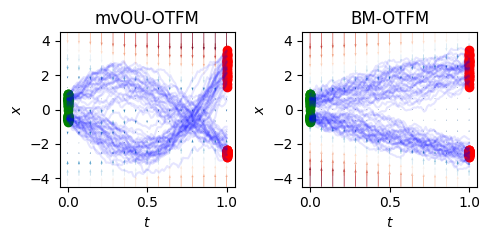

In [15]:
sde_ou = fm.SDE(lambda t, x: v_model(t, x) + sigma**2 / 2 * s_model(t, x), sigma)
sde_bm = fm.SDE(lambda t, x: v_model_null(t, x) + sigma**2 / 2 * s_model_null(t, x), sigma)
with torch.no_grad():
    xs_sde_ou = torchsde.sdeint(sde_ou, torch.tensor(x0), torch.linspace(0, 1, _T), method = "euler")
    xs_sde_bm = torchsde.sdeint(sde_bm, torch.tensor(x0), torch.linspace(0, 1, _T), method = "euler")
xs_sde_ou_proj = _project_traj(xs_sde_ou, U)
xs_sde_bm_proj = _project_traj(xs_sde_bm, U)

_ts = torch.linspace(0, 1, 15)
_ys = torch.linspace(*ylims, 15)
with torch.no_grad():
    score_ou = torch.vstack([s_model(_t, _ys.unsqueeze(1) * U[:, 0].unsqueeze(0)) @ U[:, 0] for _t in _ts]).T
    score_bm = torch.vstack([s_model_null(_t, _ys.unsqueeze(1) * U[:, 0].unsqueeze(0)) @ U[:, 0] for _t in _ts]).T

X, Y = np.meshgrid(_ts, _ys)

plt.figure(figsize = (5, 2.5))
plt.subplot(1, 2, 1)
plt.quiver(X, Y, torch.zeros_like(score_ou), score_ou, score_ou.abs(), cmap = "RdBu_r", scale_units = 'y')
plt.plot(torch.linspace(0, 1, _T), xs_sde_ou_proj[..., k], color = 'blue', alpha = 0.1);
plt.scatter(torch.zeros_like(x0_proj[:, k]), x0_proj[:, k], c = 'green', label = "$p_0$")
plt.scatter(torch.ones_like(x1_proj[:, k]), x1_proj[:, k], c = 'red', label = "$p_1$")
plt.xlabel("$t$"); plt.ylabel("$x$")
plt.ylim(*ylims)
plt.title("mvOU-OTFM")
plt.subplot(1, 2, 2)
plt.quiver(X, Y, torch.zeros_like(score_bm), score_bm, score_bm.abs(), cmap = "RdBu_r", scale_units = 'y')
plt.plot(torch.linspace(0, 1, _T), xs_sde_bm_proj[..., k], color = 'blue', alpha = 0.1);
plt.scatter(torch.zeros_like(x0_proj[:, k]), x0_proj[:, k], c = 'green', label = "$p_0$")
plt.scatter(torch.ones_like(x1_proj[:, k]), x1_proj[:, k], c = 'red', label = "$p_1$")
plt.ylim(*ylims)
plt.xlabel("$t$"); plt.ylabel("$x$")
plt.title("BM-OTFM")
plt.tight_layout()
# plt.savefig(f"../../figures/SB_general_comparison_2d_seed_{seed}_dim_{dim}_N_{N}.pdf")